# How to build a decision tree and then use it for medical classification and prediction

### Presentation
    
Imagine that you are a **medical researcher** compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y. 
  
Part of your job is to build a model to **find out which drug might be appropriate for a future patient** with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.
 
It is a sample of **multiclass classifier**, and you can use the training part of the dataset to build a **decision tree**, and then use it to predict the class of an unknown patient, or to prescribe a drug to a new patient.

Dataset: drug200.csv

In [1]:
from sklearn.pipeline import Pipeline

In [2]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

In [3]:
path = 'drug200.csv'
my_data = pd.read_csv(path)
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
my_data = pd.read_csv("drug200.csv", delimiter=",")
my_data[0:5]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [5]:
# Size of data
my_data.shape

(200, 6)

<div href="pre-processing">
    <h2>Pre-processing</h2>
</div>


<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of my_data) </li>
    <li> <b> y </b> as the <b> response vector </b> (target) </li>
</ul>


Removing the column containing the target name


In [6]:
X = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
X[0:5]


array([[23, 'F', 'HIGH', 'HIGH', 25.355],
       [47, 'M', 'LOW', 'HIGH', 13.093],
       [47, 'M', 'LOW', 'HIGH', 10.113999999999999],
       [28, 'F', 'NORMAL', 'HIGH', 7.797999999999999],
       [61, 'F', 'LOW', 'HIGH', 18.043]], dtype=object)

In [7]:
y = my_data["Drug"]
y[0:5]

0    drugY
1    drugC
2    drugC
3    drugX
4    drugY
Name: Drug, dtype: object

Some features in this dataset are categorical, such as **Sex** or **BP**. Unfortunately, Sklearn Decision Trees does not handle categorical variables. We can still convert these features to numerical values using **pandas.get_dummies()**
to convert the categorical variable into dummy/indicator variables.


In [8]:
from sklearn import preprocessing

le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 


le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])


le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

X[0:5]


array([[23, 0, 0, 0, 25.355],
       [47, 1, 1, 0, 13.093],
       [47, 1, 1, 0, 10.113999999999999],
       [28, 0, 2, 0, 7.797999999999999],
       [61, 0, 1, 0, 18.043]], dtype=object)

In [9]:
# Correlations between variables?

test = pd.DataFrame(X)

s = test.select_dtypes(include='object').columns
test[s] = test[s].astype("float")
#test.info()
abs(test.corr())

# Outcome: no

,0,1,2,3,4
0,1.000000,0.102027,0.054212,0.068234,0.063119
1,0.102027,1.000000,0.007814,0.008811,0.125008
2,0.054212,0.007814,1.000000,0.137552,0.149312
3,0.068234,0.008811,0.137552,1.000000,0.010000
4,0.063119,0.125008,0.149312,0.010000,1.000000


<hr>

<div id="setting_up_tree">
    <h2>Setting up the Decision Tree</h2>
    We will be using <b>train/test split</b> on our <b>decision tree</b>. Let's import <b>train_test_split</b> from <b>sklearn.cross_validation</b>.
</div>


In [10]:
from sklearn.model_selection import train_test_split

Now <b> train_test_split </b> will return 4 different parameters. We will name them:<br>
X_trainset, X_testset, y_trainset, y_testset <br> <br>
The <b> train_test_split </b> will need the parameters: <br>
X, y, test_size=0.3, and random_state=3. <br> <br>
The <b>X</b> and <b>y</b> are the arrays required before the split, the <b>test_size</b> represents the ratio of the testing dataset, and the <b>random_state</b> ensures that we obtain the same splits.


In [11]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

Print the shape of X_trainset and y_trainset. Ensure that the dimensions match.


In [12]:
print ('Train set:', X_trainset.shape,  y_trainset.shape)
print ('Test set:', X_testset.shape,  y_testset.shape)

Train set: (140, 5) (140,)
Test set: (60, 5) (60,)


### Modeling
   
We will first create an instance of the **DecisionTreeClassifier** called **drugTree**.
Inside of the classifier, specify **criterion="entropy"** so we can see the information gain of each node.

Other criteria are possible like “gini” and “log_loss”.
See https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

### What is entropy?

The **impurity of nodes** is calculated by **entropy** of data in the node. So, what is entropy? Entropy is the amount of information disorder or the amount of randomness in the data. The entropy in the node depends on how much random data is in that node and is calculated for each node. In decision trees, we're looking for trees that have the smallest entropy in their nodes. The entropy is used to calculate the **homogeneity** of the samples in that node. **If the samples are completely homogeneous, the entropy is zero and if the samples are equally divided it has an entropy of one.**

In [13]:
# Default parameters
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
drugTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [26]:
# Parameters
drugTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [15]:
# Feature Names
feature_names = my_data[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].columns
feature_names

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')

Next, we will fit the data with the training feature matrix <b> X_trainset </b> and training  response vector <b> y_trainset </b>


In [16]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

<AxesSubplot:>

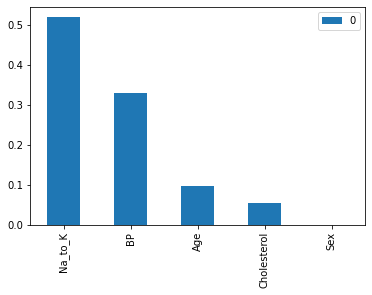

In [17]:
# Display feature importance order
feature_importance = pd.DataFrame(drugTree.feature_importances_, index = feature_names).sort_values(0, ascending = False)
feature_importance.head().plot(kind='bar')

In [18]:
###
drugTree.feature_importances_

array([0.09749785, 0.        , 0.3295848 , 0.05454991, 0.51836744])

<hr>

<div id="prediction">
    <h2>Prediction</h2>
    Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <b>predTree</b>.
</div>


In [19]:
predTree = drugTree.predict(X_testset)

You can print out <b>predTree</b> and <b>y_testset</b> if you want to visually compare the predictions to the actual values.


In [20]:
print (predTree [0:5])
print (y_testset [0:5])

['drugY' 'drugX' 'drugX' 'drugX' 'drugX']
40     drugY
51     drugX
139    drugX
197    drugX
170    drugX
Name: Drug, dtype: object


Outcome: predTree [0:5] = y_testset [0:5]  
= 100% Accuracy

### Evaluation

Next, let's import <b>metrics</b> from sklearn and check the accuracy of our model.

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.9833333333333333


**Accuracy classification score** computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


<hr>

<div id="visualization">
    <h2>Visualization</h2>

Let's visualize the tree

</div>


In [22]:
# Reminder
feature_names

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')

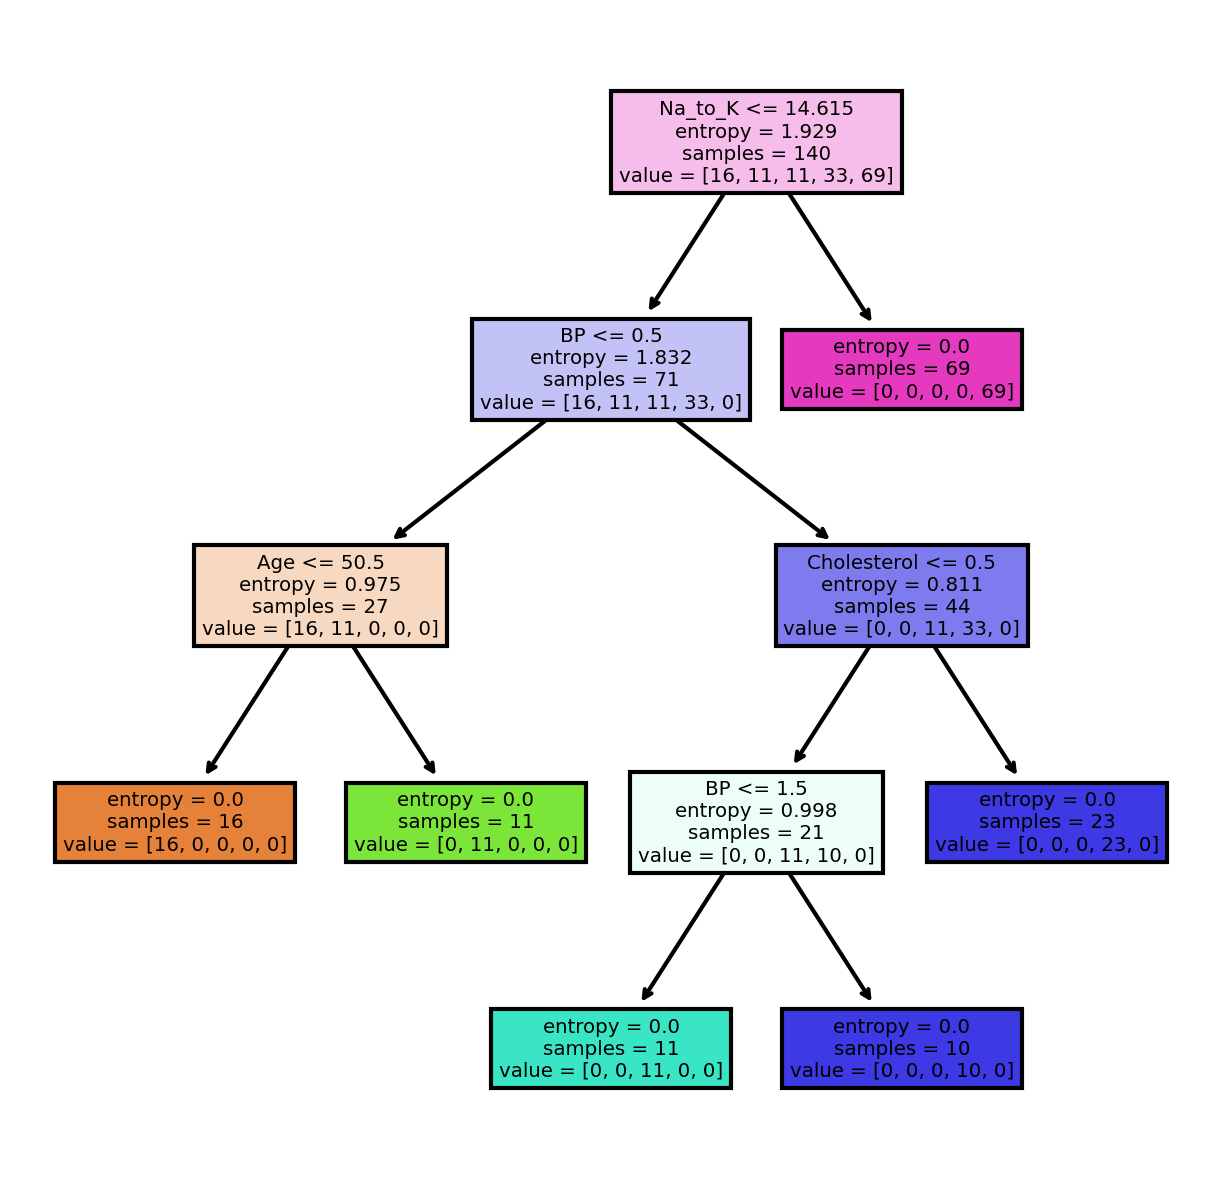

In [23]:
# Display decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=300)
tree.plot_tree(drugTree,
               feature_names = feature_names,
               filled=True)
plt.show()

In [24]:
# Other display for decision tree

from sklearn.tree import export_text
print(export_text(drugTree, feature_names = ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], show_weights=True))

|--- Na_to_K <= 14.62
|   |--- BP <= 0.50
|   |   |--- Age <= 50.50
|   |   |   |--- weights: [16.00, 0.00, 0.00, 0.00, 0.00] class: drugA
|   |   |--- Age >  50.50
|   |   |   |--- weights: [0.00, 11.00, 0.00, 0.00, 0.00] class: drugB
|   |--- BP >  0.50
|   |   |--- Cholesterol <= 0.50
|   |   |   |--- BP <= 1.50
|   |   |   |   |--- weights: [0.00, 0.00, 11.00, 0.00, 0.00] class: drugC
|   |   |   |--- BP >  1.50
|   |   |   |   |--- weights: [0.00, 0.00, 0.00, 10.00, 0.00] class: drugX
|   |   |--- Cholesterol >  0.50
|   |   |   |--- weights: [0.00, 0.00, 0.00, 23.00, 0.00] class: drugX
|--- Na_to_K >  14.62
|   |--- weights: [0.00, 0.00, 0.00, 0.00, 69.00] class: drugY



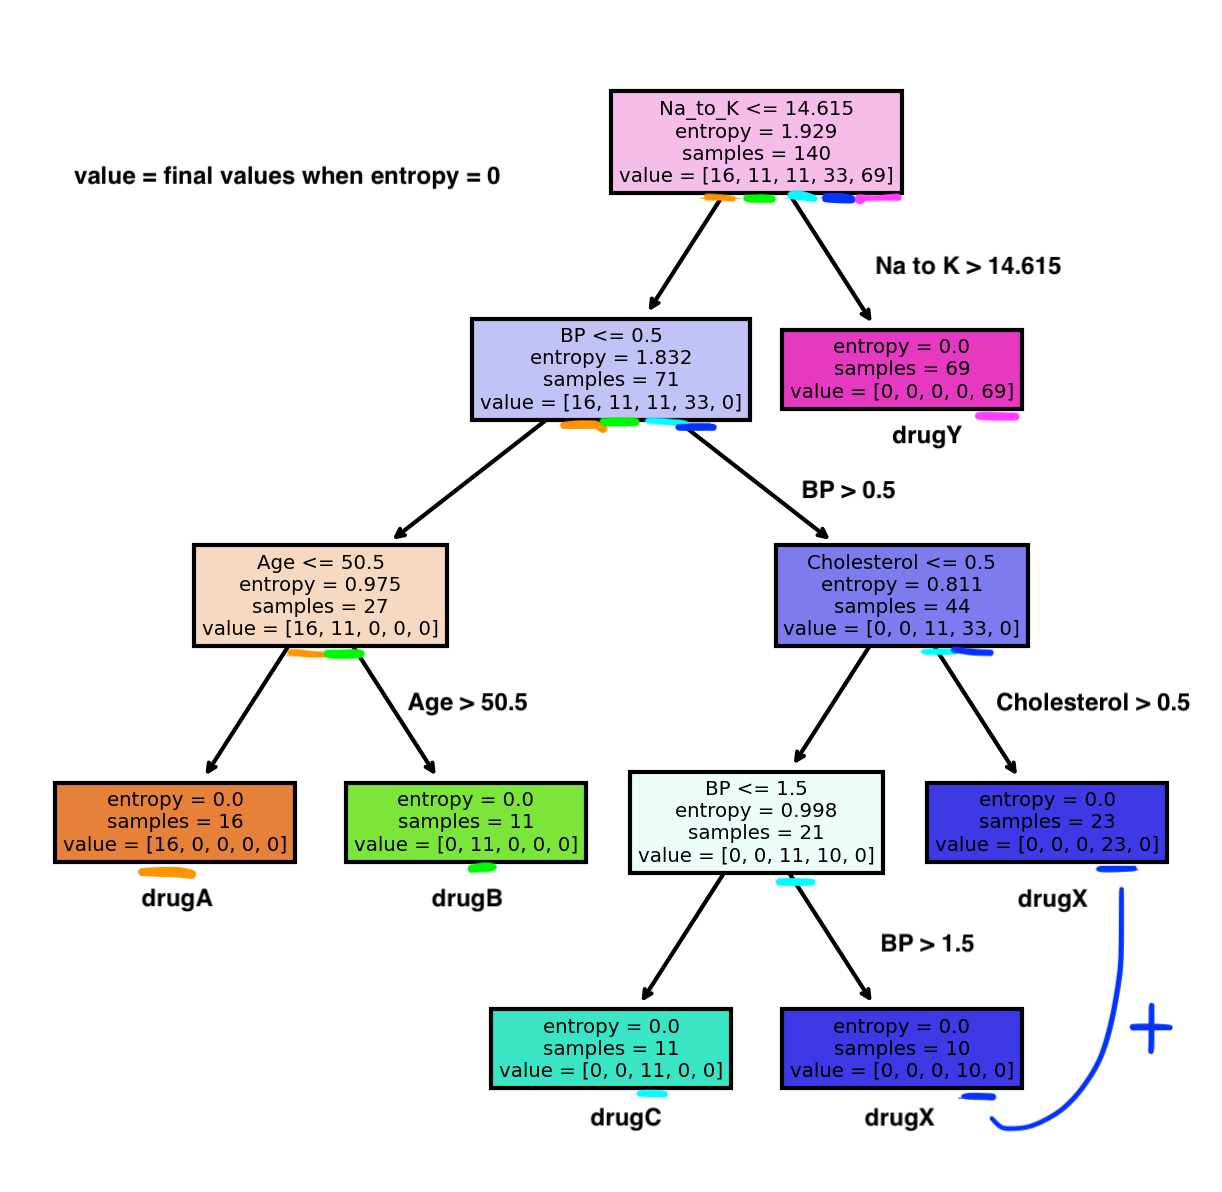

In [25]:
# Explanation 
from IPython.display import Image
i = Image(filename="a_graph_explained.png") 
display(i)